In [24]:
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal # MVN not univariate

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import time

np.random.seed(7)


np.set_printoptions(suppress=True)

file_path = "data.csv"
df = pd.read_csv(file_path, index_col='year')
df.drop(['artists','id', 'name', 'release_date','popularity' ], axis = 1, inplace = True)

### Only look at decades from 50s to 10s (2020 not included)
l_drop = np.arange(1921,1950)
l_drop = np.append(l_drop,2020)
df.drop(labels=l_drop, axis=0, inplace = True)

enc = LabelEncoder()
labels = df.index
standardized_labels = np.array(labels)
enc.fit(df.index.unique())


lmao = df.index
y = enc.transform(standardized_labels)
Y = enc.transform(np.unique(standardized_labels))

y_decade = y//10
Y_decade = np.unique(y_decade)

# enc.fit(df['explicit'].unique())
# df['explicit'] = enc.transform(df['explicit'])


df.set_index(y_decade, inplace=True)

aa = df.index.value_counts().sort_index().to_numpy()
priors = aa/len(df.index)
check = np.sum(priors)
class_priors = np.diag(priors)
num_classes = len(Y_decade)
# print(df)


N = len(df)
print('Labels:',Y_decade)
print('Total Datapoints:',N)
print("Counts Per Class:")
print(df.index.value_counts().sort_index())
df.head()

Labels: [0 1 2 3 4 5 6]
Total Datapoints: 139850
Counts Per Class:
0    19950
1    20000
2    20000
3    20000
4    20000
5    20000
6    19900
dtype: int64


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.782,0.633,106471,0.2610,1,0.0000,1,0.235,-16.389,1,0.7970,167.679,0.655
0,0.988,0.420,232933,0.0909,0,0.7860,10,0.104,-19.388,1,0.0409,123.089,0.227
0,0.993,0.394,177981,0.2580,0,0.0770,5,0.153,-9.779,0,0.1100,74.761,0.340
0,0.730,0.618,125300,0.2720,1,0.0000,6,0.146,-18.515,1,0.7310,67.141,0.449
0,0.993,0.475,188600,0.4070,0,0.0134,9,0.116,-13.011,1,0.0492,74.130,0.594


In [2]:
def regularized_cov(X, lambda_reg):
    n = X.shape[0]
    sigma = np.cov(X)
    # Selecting the regularization parameter should be performed using CV and a separate data subset
    # As I only went by training set performance (overfitting) in this problem, I settled on lambda=1/n
    sigma += lambda_reg * np.eye(n)
    return sigma

covariance = df.std()
mean = df.mean()
X = (df-df.mean())/df.std()
# print(X)
mu = X.groupby([X.index]).mean().to_numpy()
n = mu.shape[1]
Sigma = np.array([regularized_cov(X[y_decade == l].T,(1/n)) for l in range(num_classes)])
# Sigma = np.array([np.cov(X[y_decade == l].T) for l in range(num_classes)])
# print(mu)
# print(Sigma)


Total Number of Samples: 139850.0
Confusion matrix:
[[ 7134  2696   992  1148  1059   900   838]
 [11025 11410  5918  3228  3780  3213  2440]
 [ 1493  5355 11046  9441  7457  5191  3073]
 [   91   304  1463  4436  3030  1978  1218]
 [    8     9    67   213   409   132    75]
 [   18   135   339   985  1651  4752  4605]
 [  181    91   175   549  2614  3834  7651]]


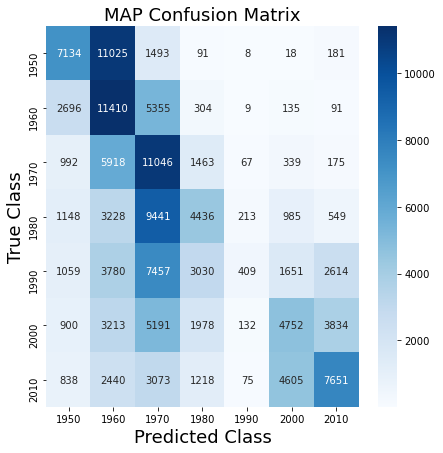

Total Number of Misclassified Samples: 93012.0
Empirically Estimated Probability of Error: 0.6651
Accuracy: 0.3349159814086522


In [3]:
C = len(priors)
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], Sigma[j]) for j in range(C)])
# print(np.max(class_cond_likelihoods))

# Class Posterior
# P(yj | x) = p(x | yj) * P(yj) / p(x)
class_posteriors = class_priors.dot(class_cond_likelihoods)

decisions = np.argmax(class_posteriors, axis=0)

sample_class_counts = np.array([sum(y == j) for j in Y_decade])


conf_mat = np.zeros((C, C))
display_mat = np.zeros((C,C))
for i in range(C): # Each decision option
    for j in range(C): # Each class label
        ind_ij = np.argwhere((decisions==Y_decade[i]) & (y_decade==Y_decade[j]))
        display_mat[i, j] = len(ind_ij) # Average over class sample count
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j]

print("Total Number of Samples:",np.sum(display_mat))
print("Confusion matrix:")
print(display_mat.astype(int))
# print(1950+(Y_decade*10))


conf_matrix_MAP = confusion_matrix(y_decade, decisions)

df_cm = pd.DataFrame(conf_matrix_MAP, index = [Y_decade[i]*10+1950 for i in Y_decade], columns = [Y_decade[i]*10+1950 for i in Y_decade])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.title('MAP Confusion Matrix', fontsize=18)
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

correct_class_samples = np.sum(np.diag(display_mat))
print("Total Number of Misclassified Samples: {}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
print("Accuracy:",1-prob_error)

acousticness        0.125656
loudness            0.118565
duration_ms         0.102303
energy              0.096222
valence             0.087639
danceability        0.086591
speechiness         0.084844
tempo               0.080085
liveness            0.075495
instrumentalness    0.067957
key                 0.047926
explicit            0.014459
mode                0.012258
dtype: float64

ACCURACY OF THE MODEL:  0.47906089858181383


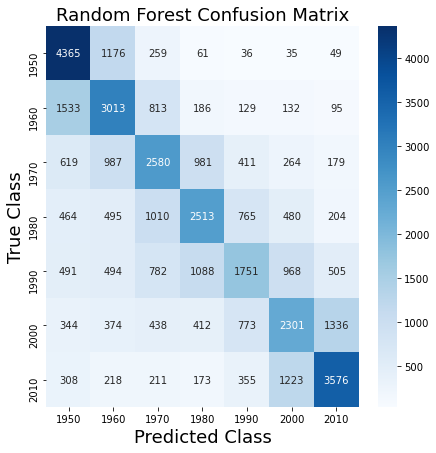


Time to run (sec):  27.307886362075806
Time to run (min):  0.4551314393679301


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y_decade, test_size = 0.30)


start = time.time()


clf = RandomForestClassifier(n_estimators = 100)

clf.fit(X_train, y_train)

feature_imp = pd.Series(clf.feature_importances_, index = df.columns).sort_values(ascending = False)

print(feature_imp)


y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


conf_matrix_RF = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(conf_matrix_RF, index = [Y_decade[i]*10+1950 for i in Y_decade],\
                     columns = [Y_decade[i]*10+1950 for i in Y_decade])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.title('Random Forest Confusion Matrix', fontsize=18)
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()


stop = time.time()
print()
print('Time to run (sec): ', stop - start) 
print('Time to run (min): ', (stop - start)/60) 

In [5]:
# conf_matrix_RF = confusion_matrix(y_test, y_pred)

# df_cm = pd.DataFrame(conf_matrix_RF, index = [Y_decade[i]*10+1950 for i in Y_decade],\
#                      columns = [Y_decade[i]*10+1950 for i in Y_decade])
# plt.figure(figsize = (7,7))
# sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
# plt.title('Random Forest Confusion Matrix', fontsize=18)
# plt.xlabel("Predicted Class", fontsize=18)
# plt.ylabel("True Class", fontsize=18)
# plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Utility to visualize PyTorch network and shapes
from torchsummary import summary
from sklearn.model_selection import KFold # Important new include
from sklearn.linear_model import LogisticRegression

torch.manual_seed(7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.device(device)

cuda


In [7]:
class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        #Hidden layer
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        # Log Softmax (faster and better than straight Softmax)
        # dim=1 refers to the dimension along which the softmax operation is computed
        # In this case computing probabilities across dim 1, i.e., along classes at output layer
        self.log_softmax = nn.LogSoftmax(dim=1) 
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        X = F.relu(X)

        # X = [batch_size, hidden_dim]
        
#         # Add another hidden layer
#         X = F.relu(X)
#         X = self.hidden_layer(X)


        # Connect to last layer and output 'logits'
        X = self.output_fc(X)
        # Squash logits to probabilities that sum up to 1
        y = self.log_softmax(X)
        return y


In [8]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):

    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
#     model = model.to(device)
#     data = data.to(device)
#     print(model.device())
    
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model
    
    
def model_predict(model, data, labels):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
#     model.to(device)
    labels.to(device)

    model.eval()
    N = len(data)
#     print(N)
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().cpu().numpy()
        Z = np.argmax(predicted_labels, 1)
#     print(labels)
    conf_mat = confusion_matrix(Z, labels.cpu())
    correct_class_samples = np.sum(np.diag(conf_mat))
    prob_error = 1 - (correct_class_samples / N)
#     print(conf_mat)
#     print("Total Number of Misclassified Samples: {:d}".format(N - correct_class_samples))
#     print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
#     print()
    return Z, prob_error, conf_mat

# Z, acc = model_predict(model,X_tensor[0],labels[0])
# print(acc)

def neuron_cross_validation(X,labels,X_tensor,l_tensor,trials):#,Xtest,labelsTest):

    K = 10
    kf = KFold(n_splits=K, shuffle=True)
    start = 1
    trials = trials
    neurons = np.arange(start, start+trials, 1)
    n_hidden = len(neurons)
    
#     X = X.to(device)
#     labels = labels.to(device)
    X_tensor = X_tensor.to(device)
    l_tensor = l_tensor.to(device)
    
    # Store predictions per degree using ordered X samples for plotting best fit lines
#     y_train_preds_ordered = np.empty(n_degs, dtype=np.ndarray)
    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    mse_valid_mk = np.empty((n_hidden, K)) 
    mse_train_mk = np.empty((n_hidden, K)) # Indexed by model m, data partition k
    acc = np.empty((n_hidden, K))
    accTest = np.empty(n_hidden)
    i = 0
    for n in neurons: 
        start_it = time.time()
        k = 0
        for train_indices, valid_indices in kf.split(X):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_tensor[train_indices]
            y_train_k = l_tensor[train_indices]
            X_train_tensor = (X_train_k)
            y_train_tensor = (y_train_k)
            
            X_valid_k = X_tensor[valid_indices]
            y_valid_k = l_tensor[valid_indices]
            X_valid_tensor = (X_valid_k)

            #Assign data to GPU
#             X_train_k.to(device)
#             y_train_k = labels[train_indices]
#             X_train_tensor = torch.FloatTensor(X_train_k)
#             y_train_tensor = torch.LongTensor(y_train_k)
            
#             X_valid_k = X[valid_indices]
#             y_valid_k = labels[valid_indices]
#             X_valid_tensor = torch.FloatTensor(X_valid_k)
            
            #Train it
            model = TwoLayerMLP(input_dim, n, output_dim)
            model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 100
            model = model_train(model, X_train_tensor, y_train_tensor, criterion, optimizer, num_epochs=num_epochs)
            
            #Validate/predict it and record p(error)
            Z, acc[i,k], conf_mat = model_predict(model,X_valid_tensor,y_valid_k)
#             Z, accTest[i,k] = model_predict(model,X_tensor_test,labelsTest)
            k += 1
        print(X_train_tensor.device)
        i+=1
#         print(i, 'done')

        stop_it = time.time()
        t = stop_it - start_it
#         print('Time to run {}th iteration: {}'.format(i,t)) 
        print('Time to run {}th iteration:'.format(i))
        print('{} minutes'.format(t/60)) 
        print()
    accuracy = np.mean(acc, axis=1)
    min_acc = np.min(accuracy)
    min_ind = np.argmin(accuracy)
    n_optimal = neurons[min_ind]
    
    return min_ind, min_acc, n_optimal, accuracy, acc#, models, accTest

In [9]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.device(device)

# return
input_dim = X.shape[1]
n_hidden_neurons = 16   #VARY THIS FOR CV
output_dim = C

# It's called an MLP but really it's not...
model = TwoLayerMLP(input_dim, n_hidden_neurons, output_dim)
model.to(device)
# Visualize network architecture
print(model)
summary(model, input_size=(n_hidden_neurons, input_dim))

# X_train, X_test, y_train, y_test

# X_arr = X.to_numpy()

# X_tensor = torch.FloatTensor(X_arr)
# l_tensor = torch.LongTensor(y_decade)


# X_arr_train = X_train.to_numpy()
# X_arr_test = X_test.to_numpy()

X_tensor_train = torch.FloatTensor(X_train)
X_tensor_test = torch.FloatTensor(X_test)


l_tensor_train = torch.LongTensor(y_train)
l_tensor_test = torch.LongTensor(y_test)


# X_tensor_train = torch.FloatTensor(X_train)
# X_tensor_test = torch.FloatTensor(X_test)


# l_tensor_train = torch.LongTensor(y_train)
# l_tensor_test = torch.LongTensor(y_test)
#     X.to(device)
#     labels.to(device)
#     X_tensor.to(device)
#     l_tensor.to(device)

print('done')
# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
print(len(X_train))
print(len(X_test))


cuda
TwoLayerMLP(
  (input_fc): Linear(in_features=13, out_features=16, bias=True)
  (hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (output_fc): Linear(in_features=16, out_features=7, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]             224
            Linear-2                [-1, 16, 7]             119
        LogSoftmax-3                [-1, 16, 7]               0
Total params: 343
Trainable params: 343
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
done
97895
41955


In [10]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

start = time.time()

# start = 5
# neurons_test = np.arange(start, start+15, 1)
# neurons = np.zeros(len(Ntrain))
# prob_error = np.zeros(len(Ntrain))

# X_train.to(device)
# y_train.to(device)
# X_tensor_train.to(device)
# l_tensor_train.to(device)

trials = 100
min_ind, min_acc, nNeurons,acc,acc_all = neuron_cross_validation(X_train,y_train,X_tensor_train,l_tensor_train,trials)
# neurons = nNeurons
prob_error = min_acc
# print(Ntrain,"Samples...")


stop = time.time()
print('end')
print()
print("Best no. of neurons:            ",nNeurons)
print("Probability of error (Training):",min_acc)
print("Accuracy (Training)            :",1-min_acc)
print('Total Time (sec): ', stop - start) 
print('Total Time (min): ', (stop - start)/60) 

cuda:0
Time to run 1th iteration:
0.051931703090667726 minutes

cuda:0
Time to run 2th iteration:
0.05267612934112549 minutes

cuda:0
Time to run 3th iteration:
0.05315853357315063 minutes

cuda:0
Time to run 4th iteration:
0.05324273506800334 minutes

cuda:0
Time to run 5th iteration:
0.053387518723805746 minutes

cuda:0
Time to run 6th iteration:
0.05389671325683594 minutes

cuda:0
Time to run 7th iteration:
0.0541809360186259 minutes

cuda:0
Time to run 8th iteration:
0.054854051272074385 minutes

cuda:0
Time to run 9th iteration:
0.05542117754618327 minutes

cuda:0
Time to run 10th iteration:
0.05565510590871175 minutes

cuda:0
Time to run 11th iteration:
0.05605153242746989 minutes

cuda:0
Time to run 12th iteration:
0.05666593313217163 minutes

cuda:0
Time to run 13th iteration:
0.057026628653208414 minutes

cuda:0
Time to run 14th iteration:
0.057043965657552084 minutes

cuda:0
Time to run 15th iteration:
0.057562323411305745 minutes

cuda:0
Time to run 16th iteration:
0.0577489

In [22]:
print("Training Set ({} Samples)".format(len(X_tensor_train)))
print("Best no. of neurons:            ",nNeurons)
print("Probability of error (Training):",min_acc)
print("Accuracy (Training):            ",1-min_acc)
# print(acc)


# plt.scatter(neurons_test,acc)
# plt.show()

Training Set (97895 Samples)
Best no. of neurons:             96
Probability of error (Training): 0.6480822254576675
Accuracy (Training):             0.35191777454233253


Test Set
Probability of error with 96 Neurons (Test): 0.656584435704922
Accuracy (Test): 0.343415564295078
Time (min):  0.011567294597625732

Percent Per Class:
0    14.265284
1    14.301037
2    14.301037
3    14.301037
4    14.301037
5    14.301037
6    14.229532
dtype: float64


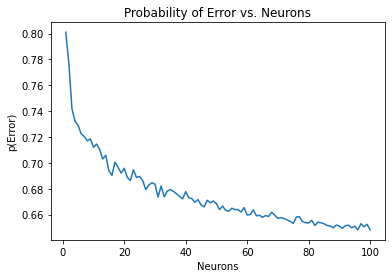

In [12]:
start = time.time()
# nNeurons = 400
model = TwoLayerMLP(input_dim, nNeurons, output_dim)
# model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
model.to(device)
X_tensor_train = X_tensor_train.to(device) 
l_tensor_train = l_tensor_train.to(device)
model = model_train(model, X_tensor_train, l_tensor_train, criterion, optimizer, num_epochs=num_epochs)

#Validate/predict it and record p(error)
# y_test_tensor = Tensor

X_tensor_test = X_tensor_test.to(device) 
l_tensor_test = l_tensor_test.to(device)
Z, accTest, conf_matrix = model_predict(model,X_tensor_test,l_tensor_test)

stop = time.time()
print('Test Set ({} Samples)'.format(len(X_tensor_test)))
print('Probability of error with', nNeurons,'Neurons (Test):',accTest)
print('Accuracy (Test):',1-accTest)
print('Time (min): ', (stop - start)/60) 
# print('Worst Value    :',1/7)
print()
print("Percent Per Class:")
print(df.index.value_counts().sort_index()/N*100)

start = 1
x_ax = np.arange(start, start+trials, 1)
plt.plot(x_ax,acc)
plt.title('Probability of Error vs. Neurons')
plt.ylabel('p(Error)')
plt.xlabel('Neurons')
plt.show()

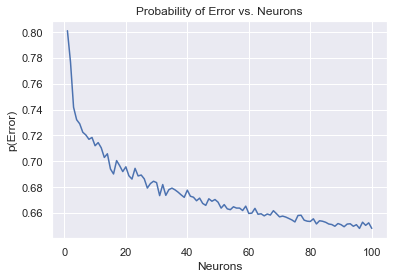

In [64]:
start = 1
x_ax = np.arange(start, start+trials, 1)
plt.plot(x_ax,acc)
plt.title('Probability of Error vs. Neurons')
plt.ylabel('p(Error)')
plt.xlabel('Neurons')
plt.show()

In [13]:
# Accuracy (Training): 0.35191777454233253
# Accuracy (Test): 0.343415564295078 

[[4314 2332 1185  853  923  666  701]
 [1106 1631  804  448  446  300  145]
 [ 333  698 1267  766  569  305  111]
 [ 107  745 1650 1958 1306  560  273]
 [  19  136  196  252  348  300  243]
 [  74  309  842 1456 1647 2763 2464]
 [  28   50   77  198  840 1084 2127]]


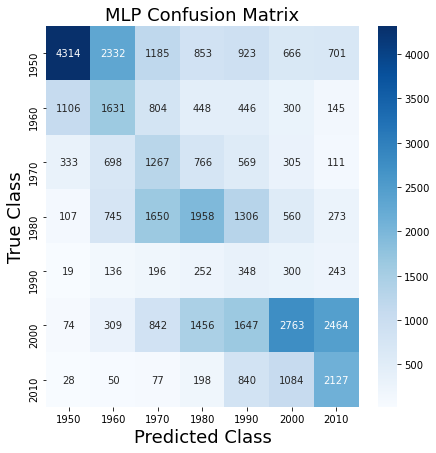

[0.39311099 0.33422131 0.31291677 0.29671162 0.23293173 0.28916797
 0.48297003]
[0.72128407 0.27639383 0.21043016 0.33012983 0.05724626 0.46219471
 0.35075858]


In [14]:
#Precision and recall of model
print(conf_matrix)
# conf_matrix = confusion_matrix(Y_test, predictions)

df_cm = pd.DataFrame(conf_matrix, index = [Y_decade[i]*10+1950 for i in Y_decade], columns = [Y_decade[i]*10+1950 for i in Y_decade])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.title('MLP Confusion Matrix', fontsize=18)
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

recall = np.zeros(len(conf_matrix))     #across
precision = np.zeros(len(conf_matrix))  #down

for i in range(len(conf_matrix)):
    recall[i] = conf_matrix[i][i]/np.sum(conf_matrix[i])
    precision[i] = conf_matrix[i][i]/np.sum(conf_matrix[:,i])
print(recall)
print(precision)

[0.39311099 0.33422131 0.31291677 0.29671162 0.23293173 0.28916797
 0.48297003]
[0.72128407 0.27639383 0.21043016 0.33012983 0.05724626 0.46219471
 0.35075858]


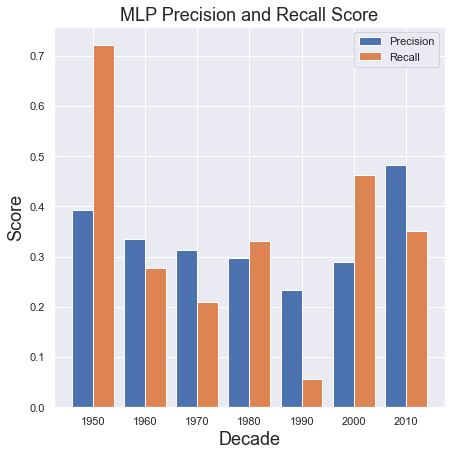

Recall  is how many of the true positives were recalled (found),
 i.e. how many of the correct hits were also found.
Precision is how many of the returned hits were true positive 
 i.e. how many of the found were correct hits.


In [63]:
prec = precision_score(y_test, Z, average=None) #will return the precision scores for each class, while
rec = recall_score(y_test, Z, average=None) #will return the total ratio of tp/(tp + fp)

print(prec)
print(rec)
sns.set()
plt.figure(figsize = (7,7))
plt.bar((Y_decade-.2)*10+1950, prec, width=4, label='Precision')
plt.bar((Y_decade+.2)*10+1950, rec, width=4, label='Recall')
plt.title('MLP Precision and Recall Score', fontsize=18)
plt.xlabel('Decade', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend()
plt.show()

print('Recall  is how many of the true positives were recalled (found),\n \
i.e. how many of the correct hits were also found.')
print('Precision is how many of the returned hits were true positive \n \
i.e. how many of the found were correct hits.')
# X_train, X_test, y_train, y_test

In [15]:
# summary(model,input_size=16)
summary(model, input_size=(nNeurons, input_dim))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 96, 96]           1,344
            Linear-2                [-1, 96, 7]             679
        LogSoftmax-3                [-1, 96, 7]               0
Total params: 2,023
Trainable params: 2,023
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.01
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [16]:
# Test Set
# Probability of error with 400 Neurons (Test): 0.6327493743296388
# Time (min):  5.017530063788096
# Accuracy (Test): 0.36725062567036115
# Worst Value    : 0.14285714285714285
# Percent Per Class:
# 0    14.265284
# 1    14.301037
# 2    14.301037
# 3    14.301037
# 4    14.301037
# 5    14.301037
# 6    14.229532


start = time.time()

model = TwoLayerMLP(input_dim, nNeurons, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
model = model_train(model, X_tensor_train, l_tensor_train, criterion, optimizer, num_epochs=num_epochs)
#Validate/predict it and record p(error)
Z, accTest = model_predict(model,X_tensor_test,y_test)

stop = time.time()

print('Probability of error with', nNeurons,'Neurons (Test):',accTest)
print('Time: ', stop - start) 
print('Time (min): ', (stop - start)/60) 

print('Accuracy (Test):',1-accTest)
print('Worst Value    :',1/7)

print(acc)